In [1]:
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction, contri, get_tensor, create_region_df_dfc_static
from create_matrix import *
from tensor_custom_core import *
import multiprocessing as mp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']

In [108]:
case = 2
setting = 'normal'
constant_use = True
static_use = True
source = 'Austin'
target = 'SanDiego'
random_seed = 0
train_percentage = 0.0
start = 1
stop = 13
year = 2014

In [109]:
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)
source_L = get_L(source_static)
target_L = get_L(target_static)

In [110]:
best_num_home_factors = 2
best_num_season_factors = 2
best_num_iterations = 900
best_learning_rate = 0.5
best_lam = 0
random_seed = 0
T_constant = np.ones(12).reshape(-1, 1)

In [111]:
H_normal, A_normal, T_normal, Hs_normal, As_normal, Ts_normal, HATs_normal, costs_normal = learn_HAT_adagrad_graph(case, target_tensor, 
                                                                                                                    target_L,
                                                          best_num_home_factors,
                                                          best_num_season_factors,
                                                          num_iter=best_num_iterations, lr=best_learning_rate, dis=False,
                                                          lam=best_lam, random_seed = random_seed, T_known=T_constant)



In [112]:
H_source, A_source, T_source, Hs_source, As_source, Ts_source, HATs_source, costs_source = learn_HAT_adagrad_graph(case, source_tensor, 
                                                                                                                    source_L,
                                                          best_num_home_factors,
                                                          best_num_season_factors,
                                                          num_iter=best_num_iterations, lr=best_learning_rate, dis=False,
                                                          lam=best_lam, random_seed = random_seed, T_known=T_constant)



In [113]:
H_transfer, A_transfer, T_transfer, Hs_transfer, As_transfer, Ts_transfer, HATs_transfer, costs_transfer = learn_HAT_adagrad_graph(case, target_tensor, 
                                                                                                                    target_L,
                                                          best_num_home_factors,
                                                          best_num_season_factors,
                                                          num_iter=best_num_iterations, lr=best_learning_rate, dis=False,
                                                          lam=best_lam, random_seed = random_seed, A_known = A_source, T_known=T_constant)



In [114]:
HAT_normal = multiply_case(H_normal, A_normal, T_normal, case)

pred_normal = {}
for appliance in APPLIANCES_ORDER[1:]:
#     pred_normal[appliance]
    pred_normal[appliance] = (pd.DataFrame(HAT_normal[:, appliance_index[appliance], :], index=target_df.index))


In [115]:
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    out[appliance] = {}
#     s = pd.concat(pred_normal[appliance]).ix[target_df.index]
    if appliance=="hvac":
        out[appliance] = compute_rmse_fraction(appliance,pred_normal[appliance][range(4, 10)],'SanDiego')[2]
    else:   
        out[appliance] = compute_rmse_fraction(appliance, pred_normal[appliance],'SanDiego')[2]

In [116]:
out

{'dw': 1.8145594012643593,
 'fridge': 6.441900698680521,
 'hvac': 12.162454274801247,
 'mw': 1.7084130518920073,
 'oven': 2.0519300001307554,
 'wm': 0.61945467363994344}

In [107]:
out

{'dw': 1.8557013677190799,
 'fridge': 6.4232839265095976,
 'hvac': 11.879888579402675,
 'mw': 1.6772051863134347,
 'oven': 2.2691659012264398,
 'wm': 0.67176609231700568}

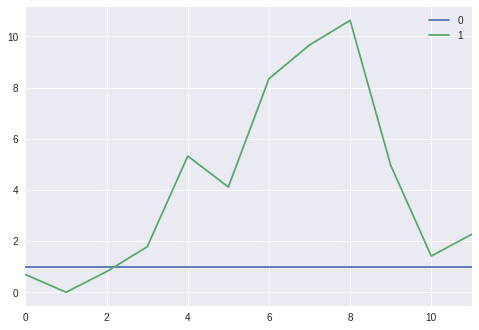

In [92]:
pd.DataFrame(T_normal).plot()
plt.savefig("./STF_normal_T.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [24]:
APPLIANCES_ORDER

['aggregate', 'hvac', 'fridge', 'mw', 'dw', 'wm', 'oven']

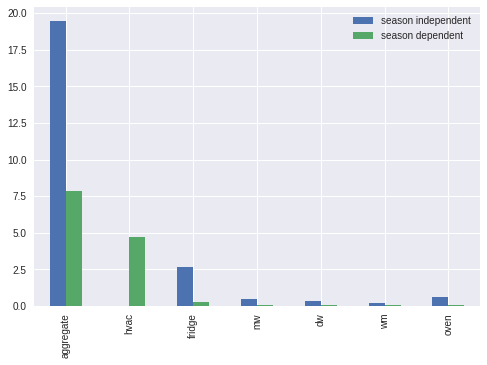

In [87]:
A_df = pd.DataFrame(A_normal)
A_df = A_df.rename(columns={0:"season independent", 1:"season dependent"}, index={0:"aggregate", 1:"hvac", 2:'fridge',
                                                                                3:"mw", 4:'dw', 5:'wm', 6:'oven'})

A_df.plot(kind='bar')
plt.savefig("./STF_normal_A.pdf", bbox_inches="tight", dpi=300, format='pdf')

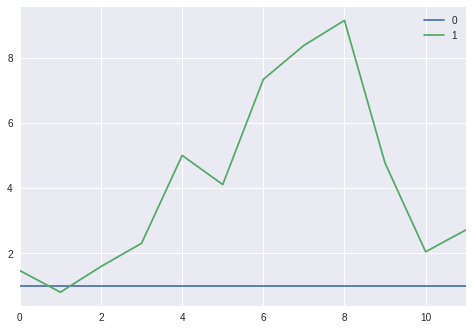

In [91]:
pd.DataFrame(T_transfer).plot()
plt.savefig("./STF_transfer_T.pdf", bbox_inches="tight", dpi=300, format='pdf')

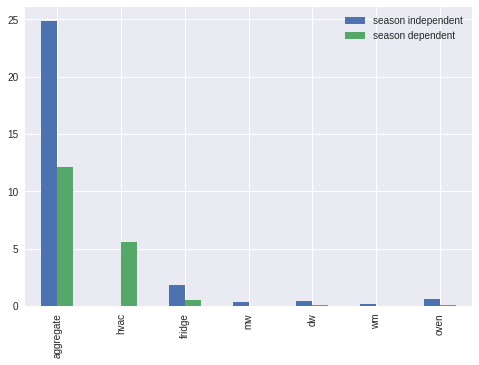

In [89]:
A_df = pd.DataFrame(A_transfer)
A_df = A_df.rename(columns={0:"season independent", 1:"season dependent"}, index={0:"aggregate", 1:"hvac", 2:'fridge',
                                                                                3:"mw", 4:'dw', 5:'wm', 6:'oven'})

A_df.plot(kind='bar')
plt.savefig("./STF_transfer_A.pdf", bbox_inches="tight", dpi=300, format='pdf')

In [78]:
appliance_mean = []
for appliance in APPLIANCES_ORDER[2:]:
#     appliance = 'wm'
    appliance_df = create_matrix_region_appliance_year('SanDiego', 2014, appliance)
    appliance_cols = [x for x in appliance_df.columns if appliance in x]
    appliance_df = appliance_df[appliance_cols]
    appliance_df.columns = range(len(appliance_cols))
#     appliance_mean.append(appliance_df.mean())
    appliance_mean = np.r_[appliance, appliance_df.mean().values()]
# appliance_energy = appliance_df.mean().div(appliance_df.mean().max())
# df.loc['Mean Energy \n(Normalised)'] = appliance_energy
# print appliance_energy
# print appliance_df.corr().heatmap()
import seaborn as sns
print appliance_mean



TypeError: 'numpy.ndarray' object is not callable

In [ ]:
for outer_loop_iteration, (train_max, test) in enumerate(kf.split(target_df)):
    # Just a random thing
    np.random.seed(10 * random_seed + 7 * outer_loop_iteration)
    np.random.shuffle(train_max)
    print("-" * 80)
    print("Progress: {}".format(100.0 * outer_loop_iteration / n_splits))
#         print(datetime.datetime.now())
#         sys.stdout.flush()
    num_train = int((train_percentage * len(train_max) / 100) + 0.5)


    if train_percentage == 100:
        train = train_max
        train_ix = target_df.index[train]
        # print("Train set {}".format(train_ix.values))
        test_ix = target_df.index[test]
    else:
        # Sample `train_percentage` homes
        # An important condition here is that all homes should have energy data
        # for all appliances for atleast one month.
        train, _ = train_test_split(train_max, train_size=train_percentage / 100.0)
        train_ix = target_df.index[train]
        test_ix = target_df.index[test]

    count = 0

#         print("******* BEST PARAMS *******")
#         print("******* BEST PARAMS *******")
    sys.stdout.flush()
    # Now we will be using the best parameter set obtained to compute the predictions
    if setting=="transfer":
        A_source = A_store[best_learning_rate][best_num_season_factors][best_num_home_factors][best_lam][best_num_iterations]
    else:
        A_source = None
    num_test = len(test_ix)
    train_test_ix = np.concatenate([test_ix, train_ix])
    df_t, dfc_t = target_df.loc[train_test_ix], target_dfc.loc[train_test_ix]
    tensor = get_tensor(df_t, start, stop)
    tensor_copy = tensor.copy()
    # First n
    tensor_copy[:num_test, 1:, :] = np.NaN
#         print tensor_copy


    L = target_L[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]

    H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L,
                                                                          best_num_home_factors,
                                                                          best_num_season_factors,
                                                                          num_iter=best_num_iterations, lr=best_learning_rate, dis=False,
                                                                          lam=best_lam, random_seed = random_seed, A_known=A_source, T_known=T_constant)


    HAT = multiply_case(H, A, T, case)
#         print HAT
    for appliance in APPLIANCES_ORDER:
        pred[appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
    best_params_global[outer_loop_iteration] = {'Learning Rate': best_learning_rate,
                                                'Iterations': best_num_iterations,
                                                'Num season factors': best_num_season_factors,
                                                'Num home factors': best_num_home_factors,
                                                'Lambda': best_lam
                                                }

for appliance in APPLIANCES_ORDER:
    pred[appliance] = pd.DataFrame(pd.concat(pred[appliance]))
for appliance in APPLIANCES_ORDER[1:]:
    prediction = pred[appliance]
    if appliance == 'hvac':
        prediction = prediction[range(5-start, 11-start)]
    out[appliance] = \
        compute_rmse_fraction(appliance, prediction, target, start, stop)[2]
print out
#     print (pd.DataFrame(out).T*pd.Series(contri['SanDiego'])).sum(axis=1)
return out
#     print("Computed for: {}".format(name))
    